# Group 4 Assignment 2 

### Authors: 
-  Chin Yee Wan 
-  Darrel Koh
-  Nguyen Gia Khanh 
-  Ngo Vu Anh	

# Discover and Visualise the Data

## Import Libraries

In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

from pyspark.mllib.regression import LabeledPoint

### Read in file

In [4]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [5]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

23/08/11 18:12:19 WARN Utils: Your hostname, Darrels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
23/08/11 18:12:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/11 18:12:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

23/08/11 18:12:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/11 18:12:32 WARN TaskSetManager: Stage 0 contains a task of very large size (1416 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

## Functions definition 

#### Custom pipeline for data pre-processing

In [7]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = True):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label:
            def label_transformer(category):
                if category == 'Normal':
                    return 0
                elif category in ['Reconnaissance', 'Analysis', 'Fuzzers', 'Shellcode', 'Generic']:
                    return 0
                elif category in ['Backdoor', 'DoS', 'Exploits', 'Worms']:
                    return 1

            df['label'] = df['attack_cat'].apply(label_transformer)
            df.drop('attack_cat', axis=1, inplace=True)

        return df

#### For visualisation

In [8]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

### For Evaluation

In [9]:
def evaluate_model(model, train_data, val_data):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Define the evaluators for accuracy, precision, recall, and F1-score
    eval_metrics = {
        'AUC': auc,
    }

    multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='label')
    metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'f1']
    for metric in metrics:
        value = multiclass_evaluator.setMetricName(metric).evaluate(predictions)
        eval_metrics[metric.capitalize()] = value

    return eval_metrics

## Data Exploration

### Convert Spark to Pandas

In [10]:
# Convert Spark DataFrames to Pandas
# train_df = train_df.toPandas()
# test_df_pandas = test_df.toPandas()
# features_df_pandas = features_df.toPandas()

### Explore the Features set

In [11]:
# features_df.head(20)
# features_df.show()

### Explore Training Dataset

In [12]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [13]:
train_df.info()
# train_df.printSchema()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [14]:
# Calculate the number of zeros in each column:
zero_counts = {}

for column in train_df.columns:
    zero_counts[column] = (train_df[column] == "0").sum()
    
# Create a DataFrame from the zero_counts dictionary
zero_counts_df = pd.DataFrame(list(zero_counts.items()), columns=['Column', 'Zero Count'])

# Display the DataFrame
print(zero_counts_df)


               Column  Zero Count
0                  id           0
1                 dur           0
2               proto           0
3             service           0
4               state           0
5               spkts           0
6               dpkts           0
7              sbytes           0
8              dbytes           0
9                rate           0
10               sttl           0
11               dttl           0
12              sload           0
13              dload           0
14              sloss           0
15              dloss           0
16             sinpkt           0
17             dinpkt           0
18               sjit           0
19               djit           0
20               swin           0
21              stcpb           0
22              dtcpb           0
23               dwin           0
24             tcprtt           0
25             synack           0
26             ackdat           0
27              smean           0
28            

In [15]:
train_df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


#### There are 4 Objects that will require Encoding
- proto 
- service
- state
- attack_cat (1 of target variables)

##### Proto Attribute:

In [16]:
# Read the unique values of the column 'proto' in the dataframe 'train_df' 
unique_values = train_df['proto'].unique()
unique_values

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


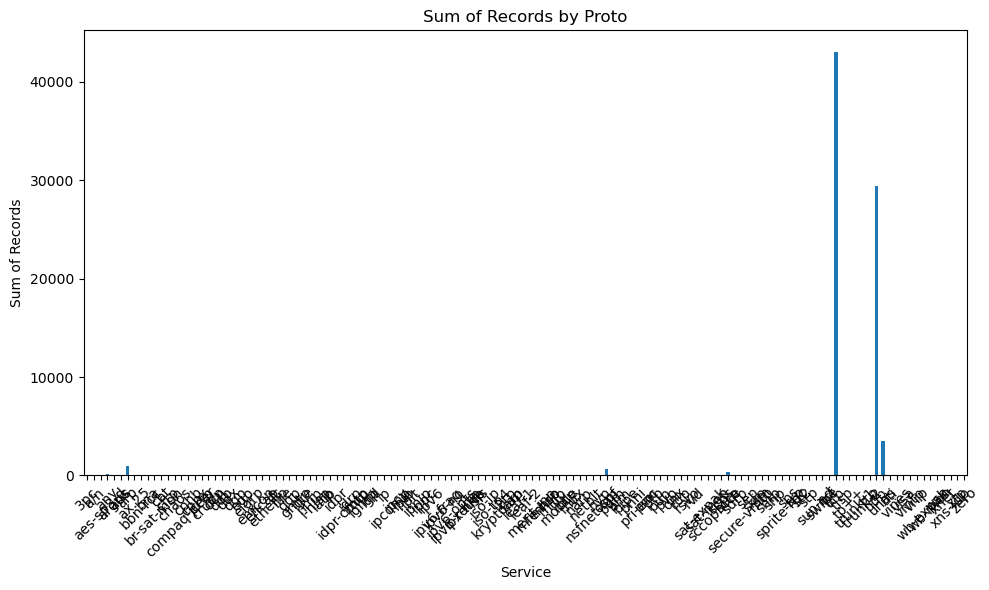

In [17]:
# Group data by 'proto' and calculate the sum for each category
proto_sum = train_df.groupby('proto').size()

# Plotting
plt.figure(figsize=(10, 6))
proto_sum.plot(kind='bar')
plt.title('Sum of Records by Proto')
plt.xlabel('Service')
plt.ylabel('Sum of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
proto_sum

proto
3pc          32
a/n          32
aes-sp3-d    32
any          96
argus        33
             ..
wsn          32
xnet         33
xns-idp      34
xtp          32
zero         32
Length: 131, dtype: int64

##### Service Attributes:
- Convert '-' to 0
- The rest normal

In [19]:
# Read the unique values of the column 'service' in the dataframe 'train_df' 
unique_values = train_df['service'].unique()
unique_values

array(['-', 'http', 'ftp', 'ftp-data', 'smtp', 'pop3', 'dns', 'snmp',
       'ssl', 'dhcp', 'irc', 'radius', 'ssh'], dtype=object)

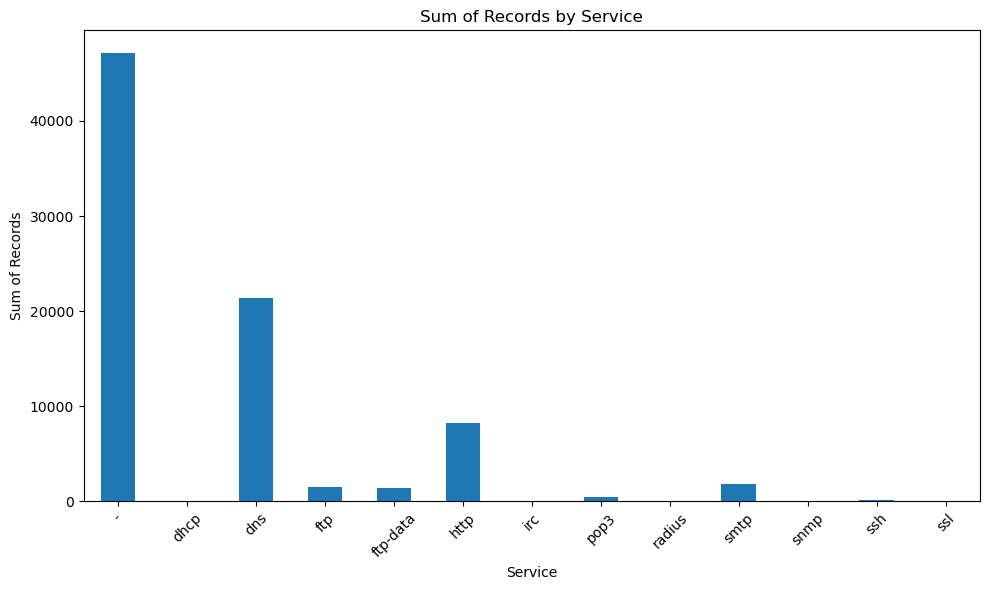

In [20]:
# Group data by 'service' and calculate the sum for each category
service_sum = train_df.groupby('service').size()

# Plotting
plt.figure(figsize=(10, 6))
service_sum.plot(kind='bar')
plt.title('Sum of Records by Service')
plt.xlabel('Service')
plt.ylabel('Sum of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
service_sum

service
-           47153
dhcp           26
dns         21367
ftp          1552
ftp-data     1396
http         8287
irc             5
pop3          423
radius          9
smtp         1851
snmp           29
ssh           204
ssl            30
dtype: int64

##### State Attribute:

In [22]:
# Read the unique values of the column 'state' in the dataframe 'train_df' 
unique_values = train_df['state'].unique()
unique_values

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO'], dtype=object)

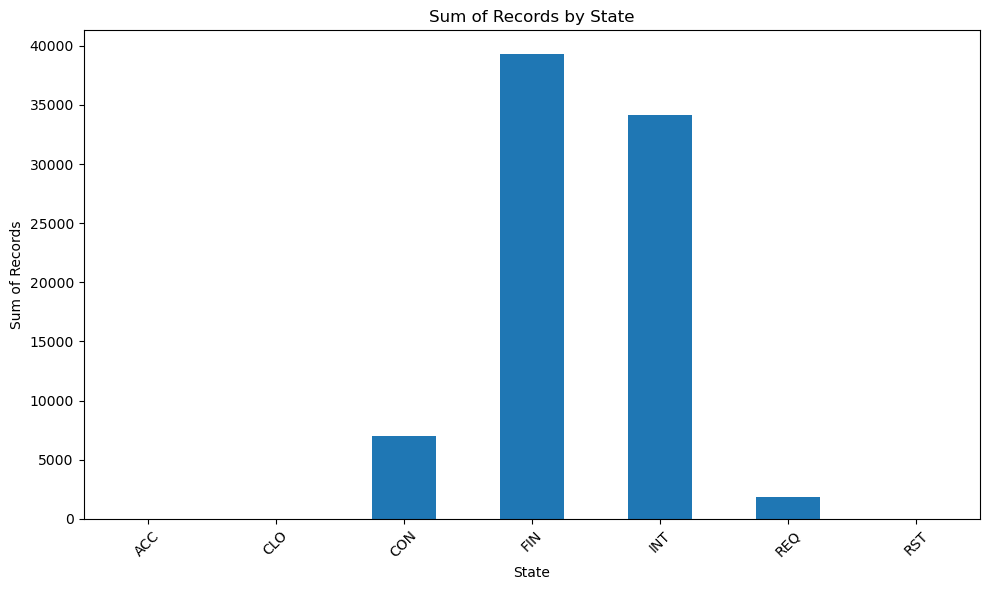

In [23]:
# Group data by 'state' and calculate the sum for each category
state_sum = train_df.groupby('state').size()

# Plotting
plt.figure(figsize=(10, 6))
state_sum.plot(kind='bar')
plt.title('Sum of Records by State')
plt.xlabel('State')
plt.ylabel('Sum of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
state_sum

state
ACC        4
CLO        1
CON     6982
FIN    39339
INT    34163
REQ     1842
RST        1
dtype: int64

##### Attack_cat Attribute:

In [25]:
# Read the unique values of the column 'attack_cat' in the dataframe 'train_df' 
# Target variable: attack_cat
unique_values = train_df['attack_cat'].unique()
unique_values

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

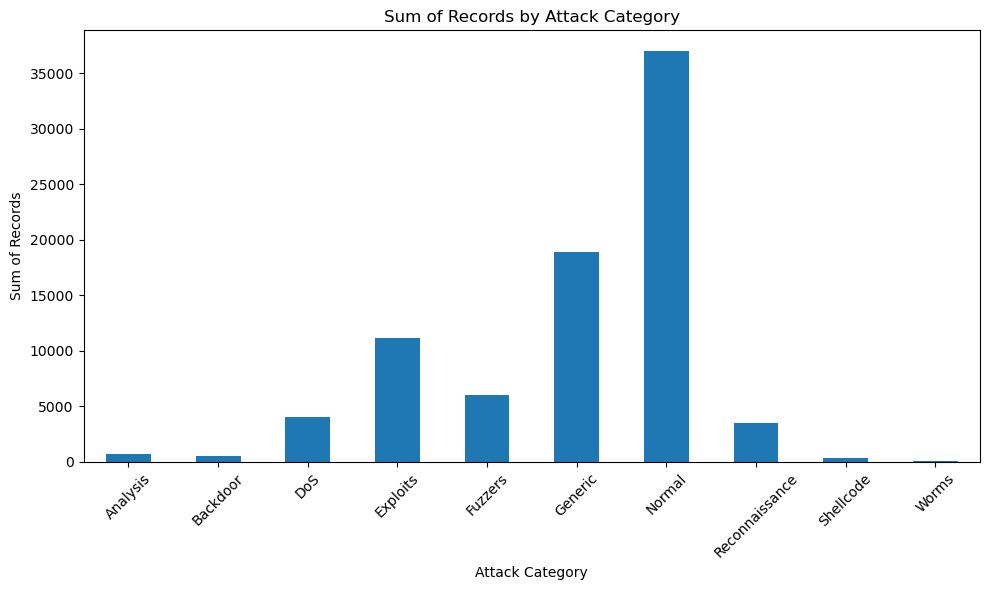

In [26]:
# Group data by 'attack_cat' and calculate the sum for each category
attack_cat_sum = train_df.groupby('attack_cat').size()

# Plotting
plt.figure(figsize=(10, 6))
attack_cat_sum.plot(kind='bar')
plt.title('Sum of Records by Attack Category')
plt.xlabel('Attack Category')
plt.ylabel('Sum of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
attack_cat_sum

attack_cat
Analysis            677
Backdoor            583
DoS                4089
Exploits          11132
Fuzzers            6062
Generic           18871
Normal            37000
Reconnaissance     3496
Shellcode           378
Worms                44
dtype: int64

In [28]:
data = {
    'attack_cat': ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
    'count': [677, 583, 4089, 11132, 6062, 18871, 37000, 3496, 378, 44]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Calculate the total count of records
total_count = df['count'].sum()

# Calculate the percentage for each attribute
df['percentage'] = (df['count'] / total_count) * 100

print(df)

       attack_cat  count  percentage
0        Analysis    677    0.822281
1        Backdoor    583    0.708109
2             DoS   4089    4.966477
3        Exploits  11132   13.520867
4         Fuzzers   6062    7.362872
5         Generic  18871   22.920614
6          Normal  37000   44.939999
7  Reconnaissance   3496    4.246223
8       Shellcode    378    0.459117
9           Worms     44    0.053442


#### Can consider dropping

- tcprtt,Float,"TCP connection setup round-trip time, the sum of ’synack’ and ’ackdat’." -use this is sufficient, 41k '0' values
- synack,Float,"TCP connection setup time, the time between the SYN and the SYN_ACK packets." - drop
- ackdat,Float,"TCP connection setup time, the time between the SYN_ACK and the ACK packets." -  drop
- ct_ftp_cmd,, No of flows that has a command in ftp session. 81652 '0' values - drop
- ct_flw_http_mthd, No. of flows that has methods such as Get and Post in http service. 74752 '0' values - drop
#### Can consider User-Transformed features
- Involved in the creation of the following features:
    - srcip: Source IP address - not in 
    - dstip: Destination IP address - not in
    - sport: Source port number - not in
    - dsport: Destination port number- not in
    - sttl: Source to destination time to live value 
    - dttl: Destination to source time to live value
    - state: "Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)"
    - service: "http, ftp, smtp, ssh, dns, ftp-data ,irc  and (-) if not much used service"
    - response_body_len: Actual uncompressed content size of the data transferred from the server’s http service
    
##### Attributes not in the dataset:
- is_sm_ips_ports,Binary,"If source (srcip) and destination (dstip) IP addresses equal and port numbers (sport)(dsport)  equal then, this variable takes value 1 else 0"
- ct_state_ttl,Integer,No. for each state (state) according to specific range of values for source/destination time to live (sttl) (dttl).
##### Attributes still in the dataset:
- ct_srv_src,integer,No. of connections that contain the same service (service) and source address (srcip) in 100 connections according to the last time (response_body_len).
- ct_srv_dst,integer,No. of connections that contain the same service (service) and destination address (dstip) in 100 connections according to the last time (response_body_len).
- ct_dst_ltm,integer,No. of connections of the same destination address (dstip) in 100 connections according to the last time (response_body_len).
- ct_src_ ltm,integer,No. of connections of the same source address (srcip) in 100 connections according to the last time (response_body_len).
- ct_src_dport_ltm,integer,No of connections of the same source address (srcip) and the destination port (dsport) in 100 connections according to the last time (response_body_len).
- ct_dst_sport_ltm,integer,No of connections of the same destination address (dstip) and the source port (sport) in 100 connections according to the last time (response_body_len).
- ct_dst_src_ltm,integer,No of connections of the same source (srcip) and the destination (dstip) address in in 100 connections according to the last time (response_body_len).

  


##### tcprtt attribute:

In [29]:
unique_values = train_df.groupby('tcprtt').size()
unique_values

# train_df['tcprtt']

tcprtt
0.000000    41127
0.000455        1
0.000464        1
0.000469        1
0.000487        1
            ...  
3.284434        1
3.525567        1
3.624389        1
3.741829        1
3.821465        1
Length: 26130, dtype: int64

##### is_sm_ips_ports attribute:

In [30]:
unique_values = train_df['is_sm_ips_ports'].unique()
unique_values

array([0, 1])

## Data Visualisation

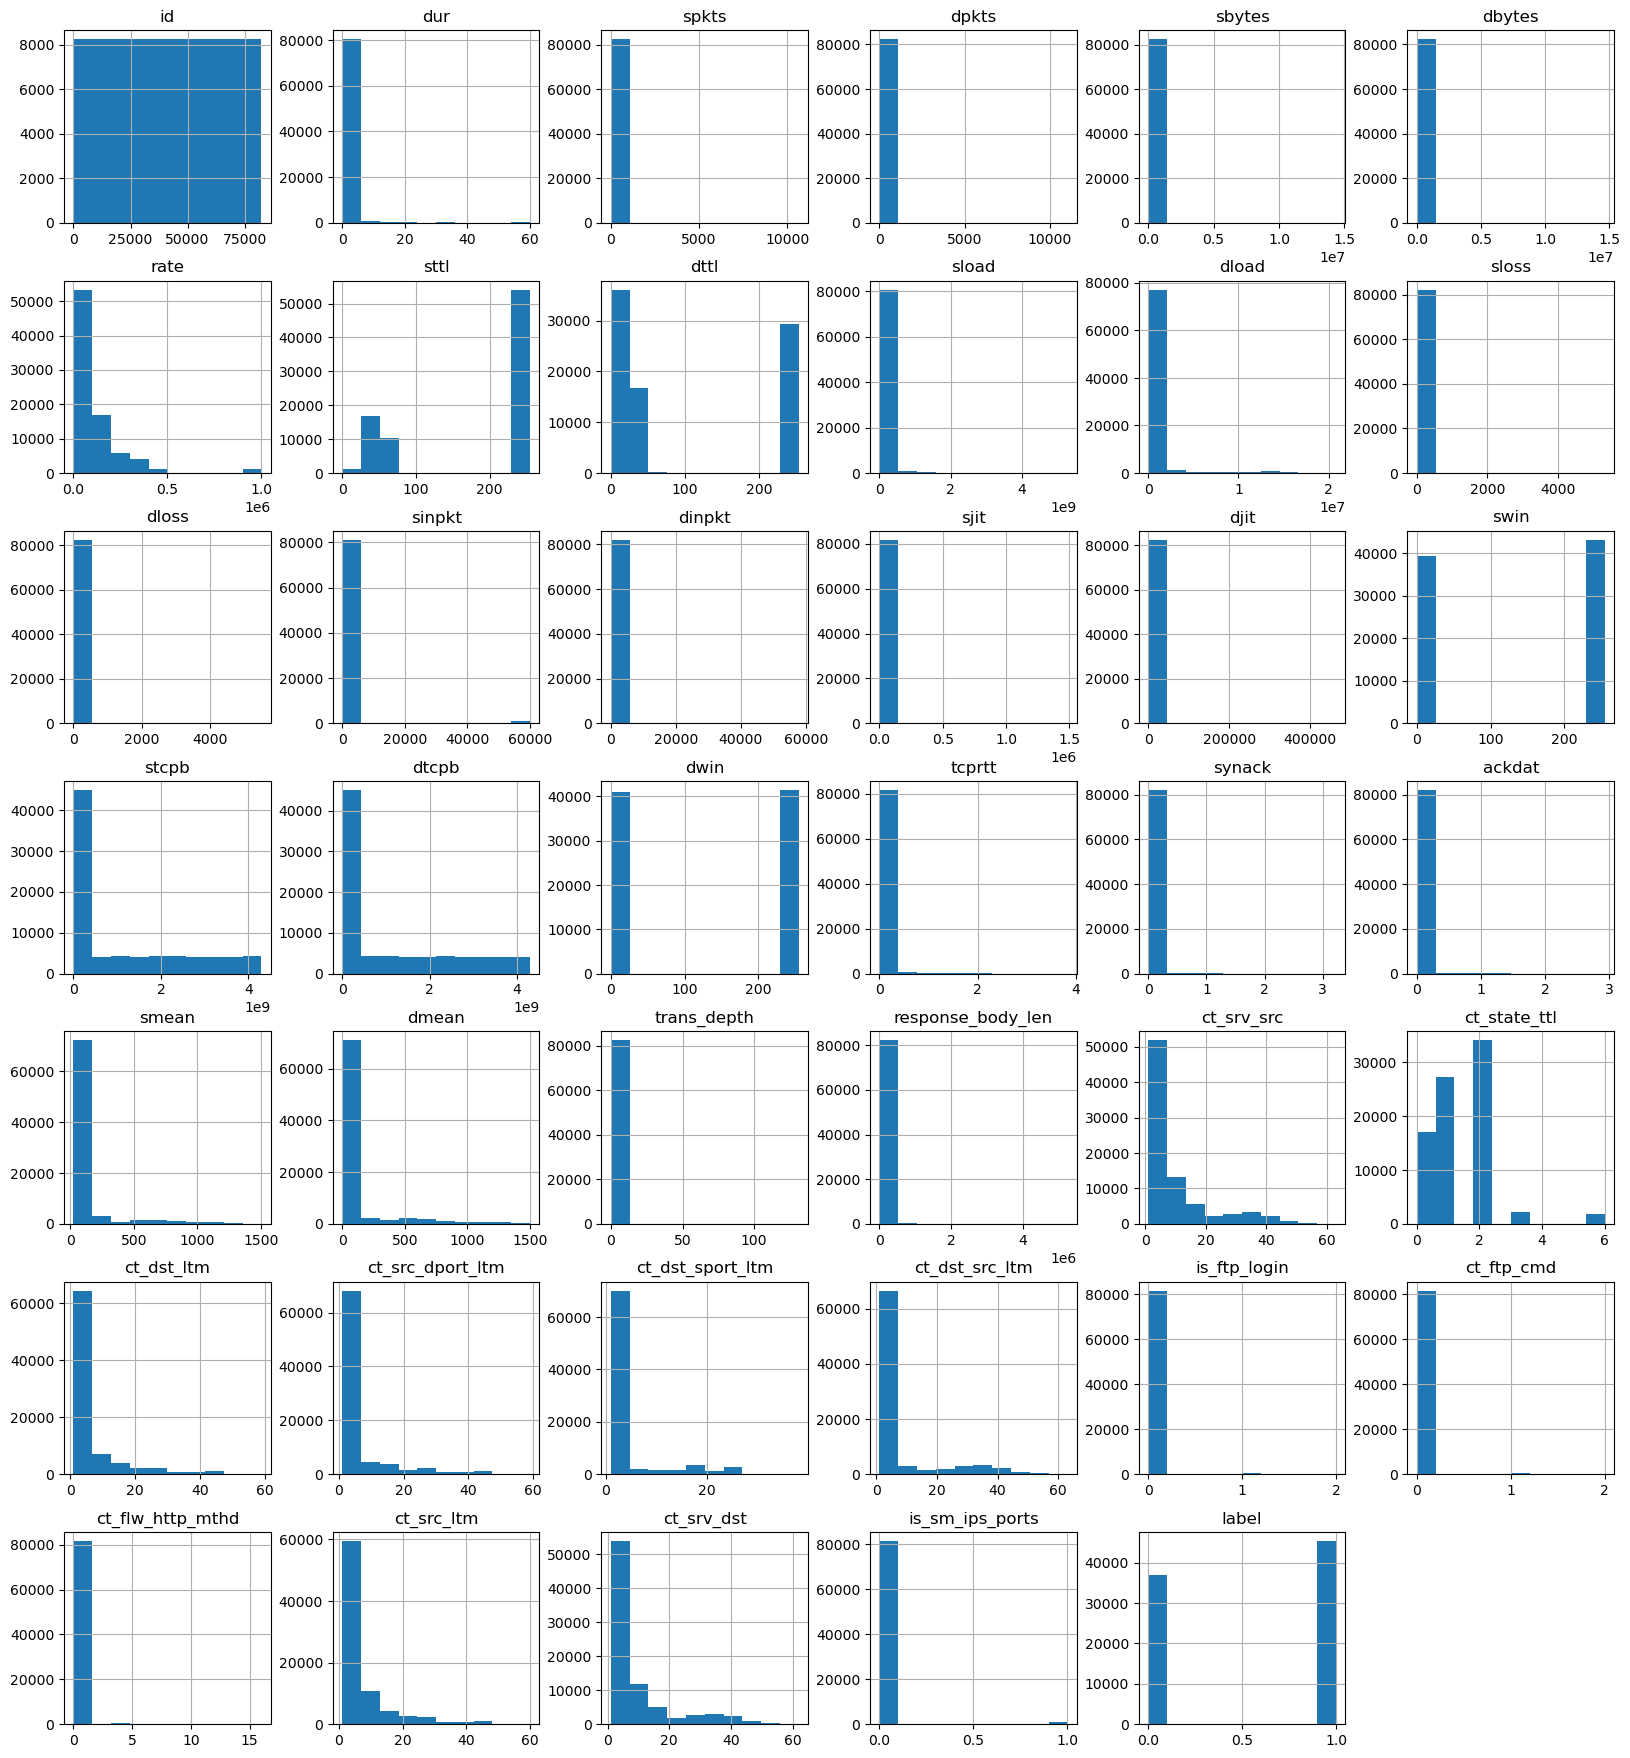

In [31]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

# Prepare the data

In [32]:
pipeline = PreProcessPipeline(label_encode=True, process_label=True)
train_df = pipeline.transform(train_df)

### Convert Pandas back to Spark

In [33]:
# Convert Pandas DataFrames back to Spark DataFrames
# train_df_spark = spark.createDataFrame(train_df)
# test_df_spark = spark.createDataFrame(test_df_pandas)

spark_df = spark.createDataFrame(train_df)
spark_df.show()

print(type(spark_df))

+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+
|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|
+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+

23/08/11 18:12:45 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


## Assemble columns into a dataframe

In [34]:
# Define the input columns (excluding the 'label' column)
input_columns = spark_df.columns[:-1]  # Exclude the last column ('label')

# Create a VectorAssembler to combine the input columns into a single 'features' column
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')

# Transform the DataFrame to add the 'features' column
assembled_df = assembler.transform(spark_df)

## Split Data

In [35]:
# Split the data into training and validation sets
train_data, val_data = assembled_df.randomSplit([0.8, 0.2], seed=123)

# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Random Forest, Multilayer perceptron).
- Split the data into training and validation sets.
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [36]:
# Example usage for default and fine-tuned models
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train_data)

lr_tuned = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100, regParam=0.01)
pipeline_tuned = Pipeline(stages=[lr_tuned])
model_tuned = pipeline_tuned.fit(train_data)

evaluation_results_default = evaluate_model(model_default, train_data, val_data)
evaluation_results_tuned = evaluate_model(model_tuned, train_data, val_data)

print("Default Model Evaluation:")
for metric, value in evaluation_results_default.items():
    print(f"{metric}: {value}")

print("\nTuned Model Evaluation:")
for metric, value in evaluation_results_tuned.items():
    print(f"{metric}: {value}")

23/08/11 18:12:46 WARN TaskSetManager: Stage 2 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/11 18:12:48 WARN TaskSetManager: Stage 4 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:49 WARN TaskSetManager: Stage 6 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:49 WARN TaskSetManager: Stage 8 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:49 WARN TaskSetManager: Stage 10 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:49 WARN TaskSetManager: Stage 12 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:12:50 WARN TaskSetManager: Stage 

Default Model Evaluation:
AUC: 0.9402970870692526
Accuracy: 0.9029965071389179
Weightedprecision: 0.899173393820988
Weightedrecall: 0.9029965071389179
F1: 0.899935540637794

Tuned Model Evaluation:
AUC: 0.9370457146167998
Accuracy: 0.8918438629818004
Weightedprecision: 0.8866585237968355
Weightedrecall: 0.8918438629818004
F1: 0.8840312001329198


23/08/11 18:12:59 WARN TaskSetManager: Stage 156 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


In [37]:
# Build the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Create a pipeline for the model
pipeline = Pipeline(stages=[lr])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the validation data
predictions = model.transform(val_data)

# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator.evaluate(predictions)

print("AUC = ", auc)

# # Define the evaluator for accuracy, precision, recall, and F1-score
# evaluator_acc = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
# evaluator_prec = MulticlassClassificationEvaluator(labelCol='label', metricName='weightedPrecision')
# evaluator_rec = MulticlassClassificationEvaluator(labelCol='label', metricName='weightedRecall')
# evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', metricName='f1')

# # Calculate the metrics
# accuracy = evaluator_acc.evaluate(predictions)
# precision = evaluator_prec.evaluate(predictions)
# recall = evaluator_rec.evaluate(predictions)
# f1_score = evaluator_f1.evaluate(predictions)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-Score:", f1_score)


# Example usage for default and fine-tuned models
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train_data)

lr_tuned = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100, regParam=0.01)
pipeline_tuned = Pipeline(stages=[lr_tuned])
model_tuned = pipeline_tuned.fit(train_data)

evaluation_results_default = evaluate_model(model_default, train_data, val_data)
evaluation_results_tuned = evaluate_model(model_tuned, train_data, val_data)

print("Default Model Evaluation:")
for metric, value in evaluation_results_default.items():
    print(f"{metric}: {value}")

print("\nTuned Model Evaluation:")
for metric, value in evaluation_results_tuned.items():
    print(f"{metric}: {value}")

23/08/11 18:12:59 WARN TaskSetManager: Stage 158 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 160 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 162 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 164 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 166 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 168 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:00 WARN TaskSetManager: Stage 170 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.

AUC =  0.9402974250522667


23/08/11 18:13:01 WARN TaskSetManager: Stage 193 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 195 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 197 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 199 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 201 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 203 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/11 18:13:02 WARN TaskSetManager: Stage 205 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.

Default Model Evaluation:
AUC: 0.9402969663610335
Accuracy: 0.9029965071389179
Weightedprecision: 0.899173393820988
Weightedrecall: 0.9029965071389179
F1: 0.899935540637794

Tuned Model Evaluation:
AUC: 0.9370428659028254
Accuracy: 0.8918438629818004
Weightedprecision: 0.8866585237968355
Weightedrecall: 0.8918438629818004
F1: 0.8840312001329198


23/08/11 18:13:07 WARN TaskSetManager: Stage 347 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

### Evaluation

## Decision Tree Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Random Forest Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Multilayer perceptron Model

### Default Model

###  Fine-Tuning 

### Evaluation

# Final comparison between Models